In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Set plot style for better visuals
plt.style.use('ggplot')

In [12]:
# --- 1. Load Raw Data ---
# Adjust these paths if your folder structure is different
try:
    df_india = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_19_india.csv')
    df_vaccine = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/covid_vaccine_statewise.csv')
    df_testing = pd.read_csv('../../RAW_DATA/Virus/Covid_19/covid_19_india/StatewiseTestingDetails.csv')
except FileNotFoundError:
    print("Error: Could not find one of the CSV files. Please check paths.")

# --- 2. Date Formatting ---
df_india['Date'] = pd.to_datetime(df_india['Date'])
# Vaccine data usually has DD/MM/YYYY format
df_vaccine['Date'] = pd.to_datetime(df_vaccine['Updated On'], dayfirst=True) 
df_testing['Date'] = pd.to_datetime(df_testing['Date'])

# --- 3. Aggregate to National Level (Daily) ---
# We sum up the states to get the total for India for each day
india_daily = df_india.groupby('Date')[['Confirmed', 'Cured', 'Deaths']].sum().reset_index()
vaccine_daily = df_vaccine.groupby('Date')[['Total Individuals Vaccinated']].sum().reset_index()
testing_daily = df_testing.groupby('Date')[['TotalSamples']].sum().reset_index()

# --- 4. Merge Dataframes ---
# Left join ensures we keep all 'Case' days, even if vaccine data is missing (NaN)
master_df = india_daily.merge(vaccine_daily, on='Date', how='left')
master_df = master_df.merge(testing_daily, on='Date', how='left')

# Fill NaN with 0 (for days before vaccines/testing started)
master_df = master_df.fillna(0)

print(f"Master Dataset Created: {len(master_df)} rows.")
print(master_df.tail())

Master Dataset Created: 560 rows.
          Date  Confirmed     Cured  Deaths  Total Individuals Vaccinated  \
555 2021-08-07   31895385  31055861  427371                           0.0   
556 2021-08-08   31934455  31099771  427862                           0.0   
557 2021-08-09   31969954  31139457  428309                           0.0   
558 2021-08-10   31998158  31180968  428682                           0.0   
559 2021-08-11   32036511  31220981  429179                           0.0   

     TotalSamples  
555   518544293.0  
556   520425081.0  
557   522104033.0  
558   523033777.0  
559           0.0  


In [13]:
# 1. Create 'Day' Count (0, 1, 2...)
start_date = master_df['Date'].min()
master_df['Day'] = (master_df['Date'] - start_date).dt.days

# 2. Add "Lockdown" Feature
# We manually tag the days where India had a strict national lockdown.
# Period: March 25, 2020 to May 31, 2020
lockdown_start = pd.to_datetime('2020-03-25')
lockdown_end = pd.to_datetime('2020-05-31')

master_df['Lockdown'] = master_df['Date'].apply(
    lambda x: 1 if (x >= lockdown_start and x <= lockdown_end) else 0
)

# Optional: Add a 'Second Wave' tag if you want (April-May 2021)
# master_df['Second_Wave'] = ... 

print("Features added: Day, Lockdown")

Features added: Day, Lockdown


In [14]:
# --- CONFIGURATION ---
# Inputs: Time + Interventions (Vaccine, Testing, Lockdown)
feature_cols = ['Day', 'Total Individuals Vaccinated', 'TotalSamples', 'Lockdown']
target_col = 'Confirmed'

poly_degree = 2  # Degree 2 (Quadratic) is usually best for Multivariate data
train_split = 0.90 # Train on first 90% of days

# --- SPLIT DATA ---
# We split by time (not random shuffle)
split_idx = int(len(master_df) * train_split)

train_df = master_df.iloc[:split_idx]
test_df = master_df.iloc[split_idx:]

X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_test = test_df[feature_cols] # NOTE: We use ACTUAL vaccine data here (as you requested)
y_test = test_df[target_col]

# --- POLYNOMIAL TRANSFORMATION ---
poly = PolynomialFeatures(degree=poly_degree)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# --- TRAIN MODEL ---
model = LinearRegression()
model.fit(X_train_poly, y_train)

print(f"Model Trained on first {len(train_df)} days.")
print(f"Testing on last {len(test_df)} days (using actual vaccine/test data).")

Model Trained on first 504 days.
Testing on last 56 days (using actual vaccine/test data).


Model Accuracy (R2 Score) on Test Data: -1478.0034


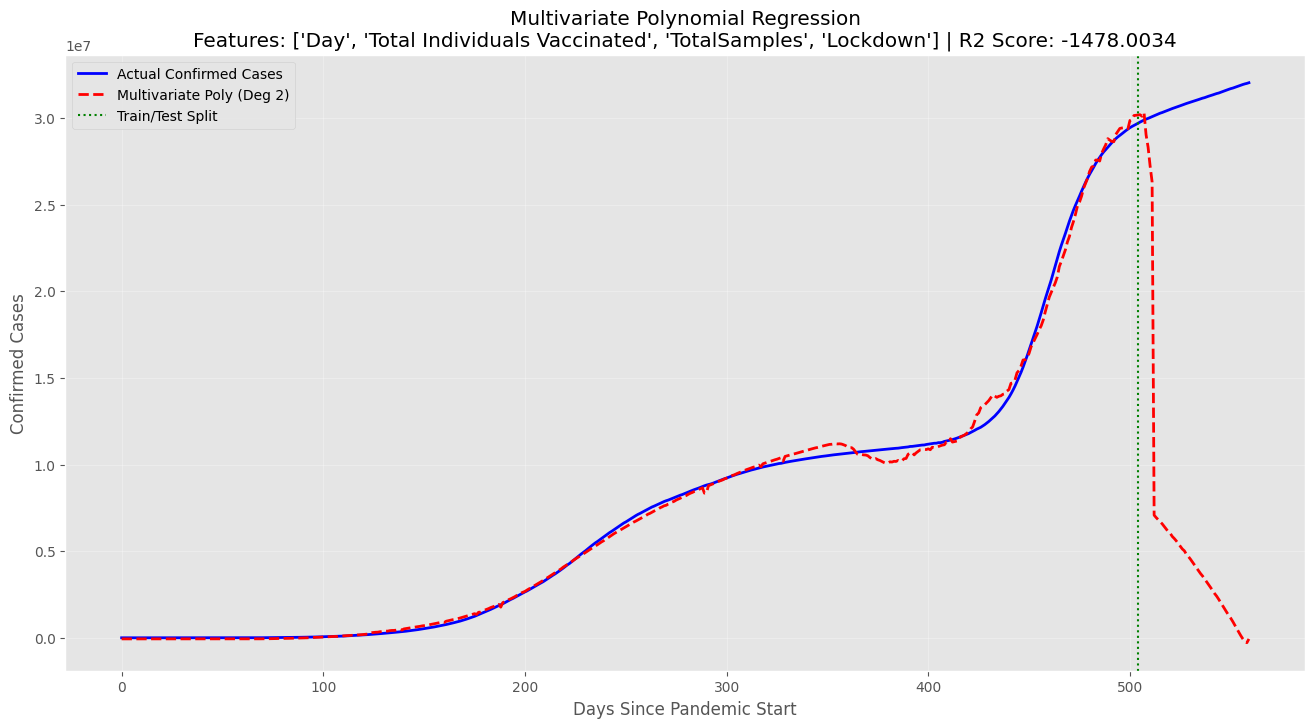

In [15]:
# 1. Predict on the Test Set
y_pred_test = model.predict(X_test_poly)

# 2. Predict on the FULL dataset (for plotting the whole line)
X_all_poly = poly.transform(master_df[feature_cols])
master_df['Predicted_Cases'] = model.predict(X_all_poly)

# 3. Calculate Accuracy
r2 = r2_score(y_test, y_pred_test)
print(f"Model Accuracy (R2 Score) on Test Data: {r2:.4f}")

# 4. Plotting
plt.figure(figsize=(16, 8))

# Plot Actual Data
plt.plot(master_df['Day'], master_df['Confirmed'], color='blue', linewidth=2, label='Actual Confirmed Cases')

# Plot Model Prediction
plt.plot(master_df['Day'], master_df['Predicted_Cases'], color='red', linestyle='--', linewidth=2, label=f'Multivariate Poly (Deg {poly_degree})')

# Visual Guides
plt.axvline(x=split_idx, color='green', linestyle=':', label='Train/Test Split')
plt.title(f'Multivariate Polynomial Regression\nFeatures: {feature_cols} | R2 Score: {r2:.4f}')
plt.xlabel('Days Since Pandemic Start')
plt.ylabel('Confirmed Cases')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()